In [1]:
import pandas as pd
from nltk import WhitespaceTokenizer
from nltk.corpus import stopwords, words, wordnet
from nltk.lm import Vocabulary
from collections import OrderedDict
import numpy as np
import torch
from torch import nn
import concurrent.futures
from torch.optim import Adam
from data_loading import process_text_df, NewsText
from utils import generate_val_set, collate_fn
from tqdm import tqdm
from models import NewsNet
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import tensor
import matplotlib.pyplot as plt

In [2]:
fake, true = pd.read_csv('Fake.csv'), pd.read_csv('True.csv')
fake['label'] = 'fake'
true['label'] = 'true'
news = pd.concat((fake, true))
news = news.sample(frac=1)
news.reset_index(inplace=True, drop=True)

In [3]:
p1 = process_text_df(news, ['title', 'text'])

In [4]:
%%time
p1.process_text_col()

CPU times: user 2.85 s, sys: 1.27 s, total: 4.12 s
Wall time: 4min 21s


In [5]:
p1.df

,title,text,subject,date,label
0,"[north, carolina, lawmak, pass, curb, incom, d...","[raleigh, nc, reuter, , north, carolina, repub...",politicsNews,"December 17, 2016",true
1,"[maldiv, rush, trade, pact, china, despit, opp...","[male, reuter, , maldiv, govern, sign, free, t...",worldnews,"December 8, 2017",true
2,"[trump, erupt, secret, meet, press, transit, c...","[donald, trump, rocki, relationship, press, ev...",News,"November 21, 2016",fake
3,"[russian, militari, syria, govern, troop, cont...","[moscow, reuter, , syrian, govern, forc, date,...",worldnews,"September 12, 2017",true
4,"[former, trump, advis, page, russian, offici, ...","[washington, reuter, , carter, page, former, f...",politicsNews,"November 7, 2017",true
...,...,...,...,...,...
44893,"[us, tax, cut, make, hous, afford, analyst]","[reuter, , us, tax, overhaul, current, propos,...",politicsNews,"December 19, 2017",true
44894,"[republican, retreat, plan, curb, press, camer...","[washington, reuter, , republicanl, senat, pan...",politicsNews,"June 13, 2017",true
44895,"[trump, play, golf, wake, damn, comey, testimoni]","[rather, stick, around, washington, follow, fo...",News,"June 11, 2017",fake
44896,"[respons, gun, owner, tri, 2nd, amend, child, ...","[okay, probabl, get, it, independ, day, weeken...",News,"July 4, 2016",fake


In [6]:
p1.tokenize_sentences()
p1.df

,title,text,subject,date,label
0,"[7354, 7353, 7352, 7351, 7350, 7349, 7348, 7347]","[0, 3831, 3989, 7324, 7354, 7353, 0, 2297, 735...",politicsNews,"December 17, 2016",true
1,"[0, 7346, 7345, 7344, 7343, 7342, 7341]","[6688, 3989, 7324, 0, 7329, 6571, 6627, 7345, ...",worldnews,"December 8, 2017",true
2,"[7340, 7339, 7338, 7337, 7336, 7335, 7334, 7333]","[6836, 7340, 1863, 6227, 7336, 6711, 5369, 684...",News,"November 21, 2016",fake
3,"[7332, 7331, 7330, 7329, 7328, 7327, 7326, 732...","[7317, 3989, 7324, 5955, 7329, 6987, 4356, 686...",worldnews,"September 12, 2017",true
4,"[7322, 7340, 7321, 7320, 7332, 7319, 7318, 731...","[6794, 3989, 7324, 4229, 7320, 7322, 6873, 688...",politicsNews,"November 7, 2017",true
...,...,...,...,...,...
44893,"[7211, 7262, 6870, 6704, 7174, 5877, 4124]","[3989, 7324, 7211, 7262, 6171, 4820, 6657, 670...",politicsNews,"December 19, 2017",true
44894,"[7314, 6808, 6719, 7350, 7336, 6653, 6085, 721...","[6794, 3989, 7324, 399, 6936, 6262, 7257, 5410...",politicsNews,"June 13, 2017",true
44895,"[7340, 6152, 4405, 5022, 4767, 7097, 6585]","[5377, 5797, 7208, 6794, 6966, 7322, 7231, 679...",News,"June 11, 2017",fake
44896,"[7026, 7025, 7024, 6550, 3975, 4959, 4489, 1376]","[4268, 5230, 6880, 7187, 7014, 7214, 3386, 155...",News,"July 4, 2016",fake


In [7]:
l, labs = p1.tensorize_sentences('text', 'label', n_feature_tokens=50)

In [8]:
idx = len(l) // 4
l_tr, labs_tr = l[:2 * idx], labs[:2 * idx]
l_val, labs_val = l[2 * idx:3 * idx], labs[2 * idx:3 * idx]
l_tst, labs_tst = l[-idx:], labs[-idx:]
tr_set = NewsText(l_tr, labs_tr)
loader = DataLoader(tr_set, batch_size=8, collate_fn=collate_fn)

val_set = NewsText(l_val, labs_val)
val_set = generate_val_set(val_set)
val_features, val_labels, val_lens = val_set
val_labels = val_labels.unsqueeze(-1).float()

net = NewsNet(p1.vocab, hidden_size=4, embedding_dim=8, num_layers=2)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(net.parameters(), lr=1e-4, weight_decay=5e-6)
loss_list = []
val_loss_list = []
accuracy_list = []
epochs = 50
pbar = tqdm(total=epochs)
for i in range(epochs):
    pbar.update()
    for sents, labels, lens in loader:
        net.train()
        labels = labels.float().unsqueeze(-1)
        out = net(sents, lens)
        loss = loss_fn(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        net.eval()
    with torch.no_grad():
        val_out = net(val_features, val_lens)
        val_loss = loss_fn(val_out, val_labels)
        val_loss_list.append(val_loss.item())
        val_guesses = torch.round(nn.Sigmoid()(val_out))
        accuracy = (val_guesses == val_labels).float().mean().item()
        
        accuracy_list.append(accuracy)
    pbar.set_description(desc=f'Completed {i + 1} out of {epochs}')
    loss_list.append(loss.item())

Completed 50 out of 50: 100%|██████████| 50/50 [37:18<00:00, 44.73s/it]

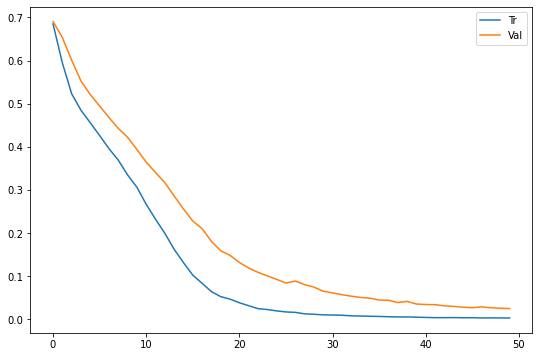

In [9]:
fig, ax = plt.subplots()
pd.Series(loss_list).plot(ax=ax, label='Tr')
pd.Series(val_loss_list).plot(ax=ax, label='Val')
fig.set_size_inches(fig.get_size_inches() * 1.5)
ax.legend()

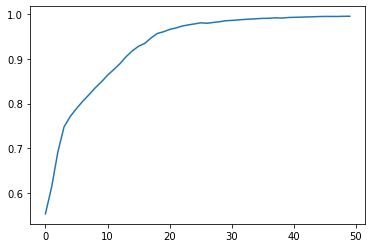

In [10]:
pd.Series(accuracy_list).plot()

In [11]:
tst_set = NewsText(l_tst, labs_tst)
tst_set = generate_val_set(tst_set)
tst_features, tst_labels, tst_lens = tst_set
tst_labels = tst_labels.unsqueeze(-1).float()

In [12]:
with torch.no_grad():
    tst_out = net(tst_features, tst_lens)
    tst_loss = loss_fn(tst_out, tst_labels)
    tst_guesses = torch.round(nn.Sigmoid()(tst_out))
    accuracy_tst = (tst_guesses == tst_labels).float().mean().item()

In [13]:
accuracy_tst

0.995933473110199